In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader , random_split
# from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

from torch.utils import data 
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
import random

from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

In [2]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


In [3]:
# Train_Path = '/home/youhan/Desktop/Cellsegmentation/CroppedTrain'
# Val_Path = '/home/youhan/Desktop/Cellsegmentation/CroppedVal'
# Test_Path = '/home/youhan/Desktop/Cellsegmentation/Croppedtest'

Annotation_Path = '/home/youhan/Desktop/Cellsegmentation/CroppedAnnotation'


class CellDataset(torch.utils.data.Dataset) :
    def __init__(self, training_dir, annotation_dir, transform , target_transform):
        super(CellDataset, self).__init__()
        self.training_dir = training_dir
        self.annotation_dir = annotation_dir
        self.imgList = os.listdir(training_dir)
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.imgList)

    def __getitem__(self, idx):
        
        image_path = os.path.join(self.training_dir, self.imgList[idx]) 
        label_path = os.path.join(self.annotation_dir,self.imgList[idx])
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        data = {'image': image, 'label': label}

        # if self.transform:
        #     torch.manual_seed(10)
        #     data['image'] = self.transform(data['image'])
        #     # data['image'] = np.transpose(data['image'], (1,2,0))
        
        # if self.target_transform:
        #     torch.manual_seed(10)
        #     data['label'] = self.target_transform(data['label'])
            
        if self.transform :
            seed = random.randint(0, 2 ** 32)
            self._set_seed(seed); data['image'] = self.target_transform(data['image'])
            self._set_seed(seed); data['label'] = self.target_transform(data['label'])
            data['image'] = self.transform(data['image'])

                          
        data['label'][data['label'] >= 0.1] = 1; data['label'][data['label'] < 0.1] = 0


        return data
    
    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)



In [4]:
# transform_train = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((256,256)),
#     # transforms.RandomHorizontalFlip(p=0.25),
#     transforms.RandomResizedCrop(size=(256,256) , scale=(0.3, 1.0)),
#     transforms.GaussianBlur(kernel_size=(7,13),sigma=(9,11)),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#     transforms.RandomHorizontalFlip(),
#     # transforms.RandomRotation(90, expand=False),
#     transforms.ToTensor()
# ])
transform_train = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(7,13),sigma=(9,11)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
])
transform_label = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((320,320)),
    transforms.RandomResizedCrop(size=(320,320) , scale=(0.3, 1.0)),
    transforms.RandomHorizontalFlip(p=0.25),
    # transforms.RandomRotation(15, expand=False),
    transforms.ToTensor()
])
transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((320,320)),
    transforms.ToTensor()
])


In [5]:
# import splitfolders
# splitfolders.ratio("/home/youhan/Desktop/Cellsegmentation/CroppedData",output='/home/youhan/Desktop/Cellsegmentation/splitcropimg', seed = 1337 , ratio=(0.8,0.1,0.1))



In [6]:

# dataset = CellDataset("/home/youhan/Desktop/Cellsegmentation/CroppedData",Annotation_Path, transform_val, transform_val)
# dataset_size = len(dataset)
# train_size = int(dataset_size * 0.8)
# validation_size = int(dataset_size * 0.1)
# test_size = dataset_size - train_size -validation_size

# train_dataset, validation_dataset , test_dataset = random_split(dataset ,[train_size, validation_size, test_size ] )

# print(f"Training Data Size : {len(train_dataset)}")
# print(f"Validation Data Size : {len(validation_dataset)}")
# print(f"Testing Data Size : {len(test_dataset)}")

In [7]:
train_dataset = CellDataset("/home/youhan/Desktop/Cellsegmentation/splitcropimg/train/input",Annotation_Path, transform_train, transform_label)
validation_dataset = CellDataset("/home/youhan/Desktop/Cellsegmentation/splitcropimg/val/input",Annotation_Path, transform_val, transform_val)
test_dataset = CellDataset("/home/youhan/Desktop/Cellsegmentation/splitcropimg/test/input",Annotation_Path, transform_val, transform_val)
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 427
Validation Data Size : 53
Testing Data Size : 54


torch.Size([320, 320, 3])
torch.Size([320, 320, 1])


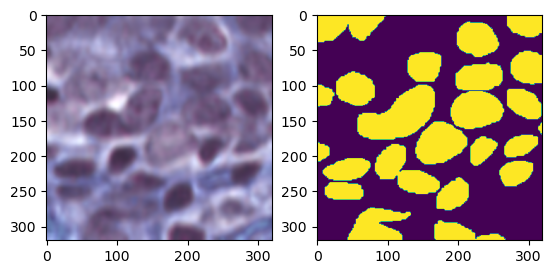

In [8]:
data = train_dataset.__getitem__(13)

image = np.transpose(data['image'], (1,2,0))
label = np.transpose(data['label'], (1,2,0))
print(image.shape)
print(label.shape)
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(label)






In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        # print(pool3.size())
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x
            

In [10]:
class DiceLoss(nn.Module):
      
    def __init__(self, smooth = 1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def dice_coef(self, y_pred, y_true):
        pred_probs = torch.sigmoid(y_pred)
        y_true_f = y_true.view(-1)
        y_pred_f = pred_probs.view(-1)
        intersection = torch.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + self.smooth)
  
    def forward(self, y_pred, y_true):
        return -self.dice_coef(y_pred, y_true)


""" 
    Class that defines the Root Mean Square Loss function.
"""
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


"""
    Class that defines the Cross Entropy Loss Function
"""
class CELoss(nn.Module):
    def __init__(self):
        super(CELoss, self).__init__()

    def forward(self, y_pred, y_true):
        return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=1)),dim=1))

"""
    Class that defines the Cross Entropy Loss Function
""" 
class WCELoss(nn.Module):
    def __init__(self):
        super(WCELoss, self).__init__()

    def forward(self, y_pred, y_true, weights):
        y_true = y_true/(y_true.sum(2).sum(2,dtype=torch.float).unsqueeze(-1).unsqueeze(-1))
        y_true[y_true != y_true] = 0.0
        y_true = torch.sum(y_true,dim=1, dtype = torch.float).unsqueeze(1)
        y_true = y_true * weights.to(torch.float)
        old_range = torch.max(y_true) - torch.min(y_true)
        new_range = 100 - 1
        y_true = (((y_true - torch.min(y_true)) * new_range) / old_range) + 1
        return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=1)),dim=1))
    
def compute_iou(A,B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def DiceCoefficient(A,B):
    intersection = np.logical_and(A,B)
    Dice_score = 2* np.sum(intersection) / (np.sum(A) + np.sum(B))
    return Dice_score

# def mean_pixel_accuracy(pixel_correct, pixel_labeled):
#     mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (
#             np.spacing(1) + np.sum(pixel_labeled))
#     return mean_pixel_accuracy



In [1]:
lr = 1e-4
batch_size = 16
num_epoch = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from torch.utils.data import DataLoader


loader_train = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
loader_val = DataLoader(validation_dataset, batch_size=16, shuffle=False, drop_last=True)
loader_test = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)
net = UNet().to(device)
fn_loss = nn.BCEWithLogitsLoss().to(device)
# fn_loss = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr = lr)

train_losses = []
val_losses = []
start_epoch =0

for epoch in range(start_epoch+1, num_epoch+1):
    net.train()
    loss_arr = []
    for batch in loader_val:
        label = batch['label'].to(device)
        input = batch['image'].to(device)
        output = net(input)
        
        optim.zero_grad()
        loss = fn_loss(output,label)

        loss.backward()
        optim.step()
        
        loss_arr += [loss.item()]
        
    print("train loss: {} epoch : {}".format(np.mean(loss_arr),epoch))
    train_losses.append(np.mean(loss_arr))


    with torch.no_grad():
        net.eval()
        loss_arr = []
    
        for batch in loader_val:
            label = batch['label'].to(device)
            input = batch['image'].to(device)
            output = net(input)
        
            loss = fn_loss(output,label)
            loss_arr += [loss.item()]
    
    print("Validation loss: {} epoch : {}".format(np.mean(loss_arr),epoch))
    if np.mean(loss_arr) < 2:
       val_losses.append(np.mean(loss_arr))

torch.save(net, '/home/youhan/Desktop/Cellsegmentation/SaveModel' + 'model.pt')
torch.save(net.state_dict(), '/home/youhan/Desktop/Cellsegmentation/SaveModel' + 'model_state_dict.pt')

# data_test = CellDataset(Test_Path,Annotation_Path, transform=transform_test)

# loader_test = DataLoader(
#     data_test,
#     batch_size=batch_size,
#     shuffle=False
# )


net.eval()

with torch.no_grad():
    mask_type = torch.float32
    total_loss = 0
    iou_score = 0
    Dice_score = 0
    accuracy = 0
    preds = []
    preds_thres = []
    labels = []
    
    for j,batch in enumerate(loader_test):
        true_masks = batch['label']
        imgs = batch['image']
        imgs = imgs.to(device)
        true_masks = true_masks.to(device)
        mask_pred = net(imgs)
        
        criterion = nn.BCEWithLogitsLoss()
        # criterion = nn.MSELoss()
        pred = mask_pred
        loss = criterion(mask_pred,true_masks)
        
        pred2 = torch.sigmoid(mask_pred)
        pred2 = (pred >=0.5).float()
        
        pred = pred.cpu().numpy()
        pred2 = pred2.cpu().numpy()
        true_masks = true_masks.cpu().numpy()
        
        preds.append(pred)
        preds_thres.append(pred2)
        labels.append(true_masks)
        total_loss += loss.item()
        
        iou_score += compute_iou(pred2,true_masks)
        Dice_score += DiceCoefficient(pred2,true_masks)
        # accuracy += mean_pixel_accuracy(pred2,true_masks)

    print((total_loss)/(j+1),'IoU : ', iou_score/(j+1) , 'DiceCoefficient :', Dice_score/(j+1) )
        




NameError: name 'torch' is not defined

0.0
1.0
(4, 1, 320, 320)


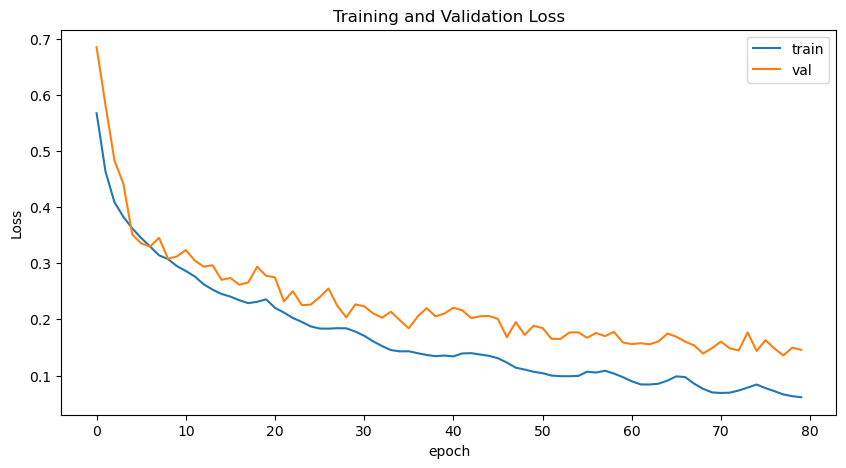

In [ ]:
#결과값 확인
print(preds_thres[4].min().item())
print(preds_thres[4].max().item())
print(preds_thres[0].shape)

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label='train')
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()




(256, 256, 1)


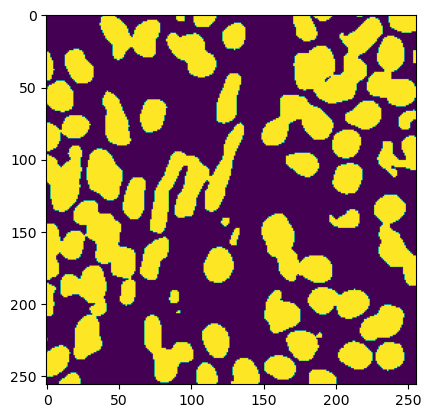

In [ ]:
# 예측 이미지 시각화

import torchvision.transforms.functional as TF
img = pred2[2].transpose(1,2,0)
print(img.shape)
plt.imshow(img)

In [ ]:
#Training

from code import interact


def pixel_accuray(output,mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output,dim=1) , dim=1)
        correct = torch.eq(output,mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
        
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes = 1):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask,dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
       
        iou_per_class = []
        for clas in range(0,n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
                
            else:
                intersect = torch.logical_and(true_class , true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class(iou)
                
        return np.nanmean(iou_per_class) # nan을 무시하고 평균을 구함.
    
    